In [ ]:
# https://mambajl.readthedocs.io/en/latest/tutorial.html#mcmc-simulation

In [42]:
using Mamba, LinearAlgebra, Distributions

In [43]:
model = Model(y = Stochastic(1,(μ , ν) ->  MvNormal(μ , sqrt(ν)), false),
              μ  = Logical(1,(xm, β) -> xm * β, false),
              β = Stochastic(1, () -> MvNormal(2, sqrt(1000))),
              ν = Stochastic(() -> InverseGamma(0.001, 0.001)) );

In [44]:
## Hybrid No-U-Turn and Slice Sampling Scheme
sc1 = [NUTS(:β), Slice(:ν, 3.0)];

## No-U-Turn Sampling Scheme
sc2 = [NUTS([:β, :ν])];

In [45]:
## User-Defined Samplers

Gibbs_β = Sampler([:β],
  (β, ν, xm, y) ->  begin
      β_mean = mean(β.distr)
      β_invcov = invcov(β.distr)
      σ = inv(Symmetric(xm' * xm / ν + β_invcov))
      μ = σ * (xm' * y / ν  +  β_invcov * β_mean)
      rand(MvNormal(μ , σ))
    end
);

Gibbs_ν = Sampler([:ν], (μ, ν, y) -> begin
      a = length(y) / 2.0 + shape(ν.distr)
      b = sum(abs2, y - μ) / 2.0 + scale(ν.distr)
      rand(InverseGamma(a, b))
    end
);

## User-Defined Sampling Scheme
sc3 = [Gibbs_β, Gibbs_ν];

In [46]:
setsamplers!(model, sc3);

In [47]:
draw(model, filename="lineDAG.dot");

In [48]:
run(`ls -l lineDAG.dot`)     # Recall wildcards do NOT work, they are a function of the shell

-rw-r--r--  1 malcolm  staff  313  1 Mar 21:41 lineDAG.dot


Process(`ls -l lineDAG.dot`, ProcessExited(0))

In [49]:
## Data
line = Dict{Symbol, Any}(:x => [1, 2, 3, 4, 5], :y => [1, 3, 3, 3, 5] )
line[:xm] = [ones(5) line[:x]];

In [51]:
## Initial Values
inits = [ Dict{Symbol, Any}( 
    :y => line[:y], :β => rand(Normal(0, 1), 2),:ν => rand(Gamma(1, 1))) for i in 1:3 ];

In [52]:
setsamplers!(model, sc1)
sim1 = mcmc(model, line, inits, 10000, burnin=250, thin=2, chains=3)

MCMC Simulation of 10000 Iterations x 3 Chains...

Chain 1:   0% [0:00:43 of 0:00:43 remaining]
Chain 1:  10% [0:00:05 of 0:00:05 remaining]
Chain 1:  20% [0:00:04 of 0:00:04 remaining]
Chain 1:  30% [0:00:03 of 0:00:04 remaining]
Chain 1:  40% [0:00:02 of 0:00:04 remaining]
Chain 1:  50% [0:00:02 of 0:00:04 remaining]
Chain 1:  60% [0:00:02 of 0:00:04 remaining]
Chain 1:  70% [0:00:01 of 0:00:04 remaining]
Chain 1:  80% [0:00:01 of 0:00:04 remaining]
Chain 1:  90% [0:00:00 of 0:00:04 remaining]
Chain 1: 100% [0:00:00 of 0:00:04 remaining]

Chain 2:   0% [0:00:05 of 0:00:05 remaining]
Chain 2:  10% [0:00:04 of 0:00:04 remaining]
Chain 2:  20% [0:00:03 of 0:00:04 remaining]
Chain 2:  30% [0:00:03 of 0:00:04 remaining]
Chain 2:  40% [0:00:02 of 0:00:04 remaining]
Chain 2:  50% [0:00:02 of 0:00:04 remaining]
Chain 2:  60% [0:00:02 of 0:00:04 remaining]
Chain 2:  70% [0:00:01 of 0:00:04 remaining]
Chain 2:  80% [0:00:01 of 0:00:04 remaining]
Chain 2:  90% [0:00:00 of 0:00:04 remaining]
Cha

Object of type "ModelChains"

Iterations = 252:10000
Thinning interval = 2
Chains = 1,2,3
Samples per chain = 4875

[3.64734 -0.165543 0.830236; 1.64717 0.622359 2.9554; … ; -0.377453 0.861288 2.51377; -1.04816 1.03941 4.57466]

[-0.194417 0.959993 0.310758; -0.194417 0.959993 0.545586; … ; 0.937305 0.757264 0.570342; 0.514069 0.898612 0.676702]

[0.412122 0.887811 0.155618; 0.412122 0.887811 0.295957; … ; 1.47301 0.684567 0.286408; 1.47301 0.684567 0.764062]

In [53]:
gelmandiag(sim1, mpsrf=true, transform=true) |> showall

Iterations = 252:10000
Thinning interval = 2
Chains = 1,2,3
Samples per chain = 4875

Gelman, Rubin, and Brooks Diagnostic:
              PSRF 97.5%
        β[1] 1.003 1.007
        β[2] 1.002 1.005
           ν 1.001 1.002
Multivariate 1.003   NaN



In [54]:
setsamplers!(model, sc2)
sim2 = mcmc(model, line, inits, 10000, burnin=250, thin=2, chains=3)

MCMC Simulation of 10000 Iterations x 3 Chains...

Chain 1:   0% [0:00:17 of 0:00:17 remaining]
Chain 1:  10% [0:00:08 of 0:00:09 remaining]
Chain 1:  20% [0:00:07 of 0:00:08 remaining]
Chain 1:  30% [0:00:06 of 0:00:09 remaining]
Chain 1:  40% [0:00:06 of 0:00:10 remaining]
Chain 1:  50% [0:00:05 of 0:00:10 remaining]
Chain 1:  60% [0:00:04 of 0:00:10 remaining]
Chain 1:  70% [0:00:03 of 0:00:09 remaining]
Chain 1:  80% [0:00:02 of 0:00:09 remaining]
Chain 1:  90% [0:00:01 of 0:00:09 remaining]
Chain 1: 100% [0:00:00 of 0:00:09 remaining]

Chain 2:   0% [0:00:22 of 0:00:22 remaining]
Chain 2:  10% [0:00:09 of 0:00:10 remaining]
Chain 2:  20% [0:00:08 of 0:00:10 remaining]
Chain 2:  30% [0:00:07 of 0:00:11 remaining]
Chain 2:  40% [0:00:06 of 0:00:11 remaining]
Chain 2:  50% [0:00:05 of 0:00:10 remaining]
Chain 2:  60% [0:00:04 of 0:00:10 remaining]
Chain 2:  70% [0:00:03 of 0:00:09 remaining]
Chain 2:  80% [0:00:02 of 0:00:09 remaining]
Chain 2:  90% [0:00:01 of 0:00:09 remaining]
Cha

Object of type "ModelChains"

Iterations = 252:10000
Thinning interval = 2
Chains = 1,2,3
Samples per chain = 4875

[-2.30073 1.46109 0.858007; -1.76447 1.44501 0.557872; … ; 0.330688 0.80487 1.27415; 0.866933 1.03363 2.10998]

[1.0025 1.0749 4.25949; -0.626777 0.989899 6.57991; … ; 0.125483 0.74288 0.715744; 1.56073 0.617601 0.538049]

[1.55877 0.518317 0.671432; 1.7954 0.367821 0.935826; … ; -0.769497 1.15313 0.790282; -0.155222 1.10723 0.610313]

In [55]:
gelmandiag(sim2, mpsrf=true, transform=true) |> showall

Iterations = 252:10000
Thinning interval = 2
Chains = 1,2,3
Samples per chain = 4875

Gelman, Rubin, and Brooks Diagnostic:
              PSRF 97.5%
        β[1] 1.000 1.000
        β[2] 1.003 1.003
           ν 1.003 1.011
Multivariate 1.006   NaN



In [56]:
setsamplers!(model, sc3)
sim3 = mcmc(model, line, inits, 10000, burnin=250, thin=2, chains=3)

MCMC Simulation of 10000 Iterations x 3 Chains...

Chain 1:   0% [0:01:08 of 0:01:08 remaining]
Chain 1:  10% [0:00:01 of 0:00:01 remaining]
Chain 1:  20% [0:00:01 of 0:00:01 remaining]
Chain 1:  30% [0:00:00 of 0:00:01 remaining]
Chain 1:  40% [0:00:00 of 0:00:01 remaining]
Chain 1:  50% [0:00:00 of 0:00:01 remaining]
Chain 1:  60% [0:00:00 of 0:00:01 remaining]
Chain 1:  70% [0:00:00 of 0:00:01 remaining]
Chain 1:  80% [0:00:00 of 0:00:00 remaining]
Chain 1:  90% [0:00:00 of 0:00:00 remaining]
Chain 1: 100% [0:00:00 of 0:00:00 remaining]

Chain 2:   0% [0:00:00 of 0:00:00 remaining]
Chain 2:  10% [0:00:00 of 0:00:00 remaining]
Chain 2:  20% [0:00:00 of 0:00:00 remaining]
Chain 2:  30% [0:00:00 of 0:00:00 remaining]
Chain 2:  40% [0:00:00 of 0:00:00 remaining]
Chain 2:  50% [0:00:00 of 0:00:00 remaining]
Chain 2:  60% [0:00:00 of 0:00:00 remaining]
Chain 2:  70% [0:00:00 of 0:00:00 remaining]
Chain 2:  80% [0:00:00 of 0:00:00 remaining]
Chain 2:  90% [0:00:00 of 0:00:00 remaining]
Cha

Object of type "ModelChains"

Iterations = 252:10000
Thinning interval = 2
Chains = 1,2,3
Samples per chain = 4875

[0.426038 0.762213 1.76958; 0.415926 0.77513 0.974313; … ; 0.93943 0.775463 0.285071; 0.819423 0.76415 0.114901]

[0.967318 0.671437 0.445779; 2.02718 0.156877 1.15133; … ; 0.210334 1.01084 0.505689; -1.5907 1.55466 3.19851]

[-1.23756 1.28848 0.555628; 1.49902 0.369071 0.610853; … ; 0.701237 0.765929 1.53086; 1.93704 0.487825 0.539024]

In [57]:
gelmandiag(sim3, mpsrf=true, transform=true) |> showall

Iterations = 252:10000
Thinning interval = 2
Chains = 1,2,3
Samples per chain = 4875

Gelman, Rubin, and Brooks Diagnostic:
              PSRF 97.5%
        β[1] 1.001 1.001
        β[2] 1.001 1.001
           ν 1.001 1.003
Multivariate 1.002   NaN



---

In [58]:
sim = sim1

Object of type "ModelChains"

Iterations = 252:10000
Thinning interval = 2
Chains = 1,2,3
Samples per chain = 4875

[3.64734 -0.165543 0.830236; 1.64717 0.622359 2.9554; … ; -0.377453 0.861288 2.51377; -1.04816 1.03941 4.57466]

[-0.194417 0.959993 0.310758; -0.194417 0.959993 0.545586; … ; 0.937305 0.757264 0.570342; 0.514069 0.898612 0.676702]

[0.412122 0.887811 0.155618; 0.412122 0.887811 0.295957; … ; 1.47301 0.684567 0.286408; 1.47301 0.684567 0.764062]

In [59]:
gewekediag(sim) |> showall

Iterations = 252:10000
Thinning interval = 2
Chains = 1,2,3
Samples per chain = 4875

Geweke Diagnostic:
First Window Fraction = 0.1
Second Window Fraction = 0.5

     Z-score p-value
β[1]   0.506  0.6126
β[2]  -1.014  0.3106
   ν   1.329  0.1839

     Z-score p-value
β[1]  -0.084  0.9334
β[2]  -0.157  0.8755
   ν  -0.425  0.6706

     Z-score p-value
β[1]   0.429  0.6680
β[2]  -0.361  0.7179
   ν  -1.742  0.0815



In [60]:
heideldiag(sim) |> showall

Iterations = 252:10000
Thinning interval = 2
Chains = 1,2,3
Samples per chain = 4875

Heidelberger and Welch Diagnostic:
Target Halfwidth Ratio = 0.1
Alpha = 0.05

     Burn-in Stationarity p-value    Mean     Halfwidth  Test
β[1]     251            1  0.1808  0.6661305 0.060145701    1
β[2]     251            1  0.0935  0.7824357 0.017395510    1
   ν     251            1  0.3646  1.0420065 0.095402662    1

     Burn-in Stationarity p-value    Mean     Halfwidth  Test
β[1]     251            1  0.8188 0.57686778  0.05552090    1
β[2]     251            1  0.8861 0.80748595  0.01593989    1
   ν     251            1  0.7312 1.04785876  0.12676010    0

     Burn-in Stationarity p-value    Mean     Halfwidth  Test
β[1]     251            1  0.8228  0.5777618 0.056460675    1
β[2]     251            1  0.7787  0.8054835 0.016020234    1
   ν     251            1  0.5232  1.1836930 0.292152246    0



In [61]:
rafterydiag(sim) |> showall

Iterations = 252:10000
Thinning interval = 2
Chains = 1,2,3
Samples per chain = 4875

Raftery and Lewis Diagnostic:
Quantile (q) = 0.025
Accuracy (r) = 0.005
Probability (s) = 0.95

     Thinning Burn-in    Total   Nmin Dependence Factor
β[1]        2     271 2.1093×10⁴ 3746         5.6308062
β[2]        2     265 1.6049×10⁴ 3746         4.2843033
   ν        2     257 8.6890×10³ 3746         2.3195408

     Thinning Burn-in    Total   Nmin Dependence Factor
β[1]        2     269 2.0647×10⁴ 3746         5.5117459
β[2]        4     271 2.5831×10⁴ 3746         6.8956220
   ν        2     257 8.4090×10³ 3746         2.2447944

     Thinning Burn-in    Total   Nmin Dependence Factor
β[1]        2     271 2.1549×10⁴ 3746         5.7525360
β[2]        4     267 1.8331×10⁴ 3746         4.8934864
   ν        2     257 8.2090×10³ 3746         2.1914042



In [ ]:
# https://mambajl.readthedocs.io/en/latest/mcmc/chains.html#section-convergence-diagnostics

In [62]:
## Summary Statistics
describe(sim)

Iterations = 252:10000
Thinning interval = 2
Chains = 1,2,3
Samples per chain = 4875

Empirical Posterior Estimates:
        Mean       SD       Naive SE      MCSE        ESS   
β[1] 0.6069200 1.07341065 0.008876014 0.016746056 4108.72190
β[2] 0.7984684 0.32376414 0.002677200 0.004784984 4578.21785
   ν 1.0911861 1.40365424 0.011606792 0.048496129  837.73397

Quantiles:
         2.5%       25.0%       50.0%      75.0%     97.5%  
β[1] -1.54170371 0.028361366 0.60694753 1.18917177 2.7976852
β[2]  0.13584976 0.623769205 0.79784229 0.97294898 1.4417826
   ν  0.16788738 0.384784960 0.65347871 1.20108193 4.8562314



In [63]:
## Highest Posterior Density Intervals
hpd(sim)

       95% Lower  95% Upper
β[1] -1.557388429 2.7704714
β[2]  0.162541143 1.4613364
   ν  0.078111601 3.4325729



In [64]:
## Lag-Autocorrelations
autocor(sim)

        Lag 2      Lag 10       Lag 20       Lag 100   
β[1] 0.36801437  0.022157980 -0.018299927   0.019421987
β[2] 0.29874174  0.024532763 -0.014743019   0.023118494
   ν 0.63426606  0.151135563  0.022202095  -0.019818315

        Lag 2      Lag 10       Lag 20       Lag 100   
β[1] 0.31476541 -0.005357285 -0.010952599 -0.0097466631
β[2] 0.27726187 -0.010912506 -0.018570990  0.0017646434
   ν 0.71699363  0.261281578  0.060996580 -0.0527359944

        Lag 2      Lag 10       Lag 20       Lag 100   
β[1] 0.25755304  0.008126971  0.012362799  0.0047385102
β[2] 0.23006461  0.016845780 -0.010167740  0.0105064402
   ν 0.85838974  0.583406297  0.341386350  0.0057040835



In [65]:
## State Space Change Rate (per Iteration)
changerate(sim)

             Change Rate
        β[1]       0.839
        β[2]       0.839
           ν       1.000
Multivariate       1.000



In [66]:
## Deviance Information Criterion
dic(sim3)

MCMC Processing of 4875 Iterations x 3 Chains...

Chain 1:   0% [0:00:00 of 0:00:00 remaining]
Chain 1:  10% [0:00:00 of 0:00:00 remaining]
Chain 1:  20% [0:00:00 of 0:00:00 remaining]
Chain 1:  30% [0:00:00 of 0:00:00 remaining]
Chain 1:  40% [0:00:00 of 0:00:00 remaining]
Chain 1:  50% [0:00:00 of 0:00:00 remaining]
Chain 1:  60% [0:00:00 of 0:00:00 remaining]
Chain 1:  70% [0:00:00 of 0:00:00 remaining]
Chain 1:  80% [0:00:00 of 0:00:00 remaining]
Chain 1:  90% [0:00:00 of 0:00:00 remaining]
Chain 1: 100% [0:00:00 of 0:00:00 remaining]

Chain 2:   0% [0:00:35 of 0:00:35 remaining]
Chain 2:  10% [0:00:01 of 0:00:01 remaining]
Chain 2:  20% [0:00:00 of 0:00:00 remaining]
Chain 2:  30% [0:00:00 of 0:00:00 remaining]
Chain 2:  40% [0:00:00 of 0:00:00 remaining]
Chain 2:  50% [0:00:00 of 0:00:00 remaining]
Chain 2:  60% [0:00:00 of 0:00:00 remaining]
Chain 2:  70% [0:00:00 of 0:00:00 remaining]
Chain 2:  80% [0:00:00 of 0:00:00 remaining]
Chain 2:  90% [0:00:00 of 0:00:00 remaining]
Chai

      DIC    Effective Parameters
pD 13.559515            0.6906472
pV 25.026696            6.4242378



In [67]:
## Subset Sampler Output
sim = sim[1000:5000, ["β[1]", "β[2]"], :]
describe(sim)

Iterations = 1000:5000
Thinning interval = 2
Chains = 1,2,3
Samples per chain = 2001

Empirical Posterior Estimates:
        Mean        SD       Naive SE       MCSE       ESS   
β[1] 0.61152741 1.05263620 0.0135860789 0.027538687 1461.0671
β[2] 0.79852677 0.31425482 0.0040559984 0.007965027 1556.6443

Quantiles:
         2.5%       25.0%      50.0%      75.0%     97.5%  
β[1] -1.47492899 0.03556112 0.61641733 1.17710212 2.7156609
β[2]  0.15749105 0.62782966 0.79231676 0.96882062 1.4281372



In [68]:
using Gadfly

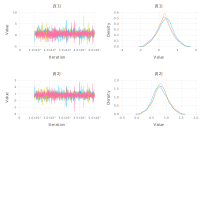

In [69]:
p = plot(sim)

draw(p, filename="summaryplot.svg")
draw(p)

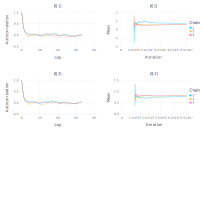

In [70]:
## Autocorrelation and running mean plots
p = plot(sim, [:autocor, :mean], legend=true)

draw(p, nrow=3, ncol=2, filename="autocormeanplot.svg")
draw(p, nrow=3, ncol=2)

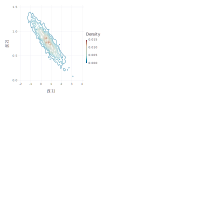

In [71]:
## Pairwise contour plots
p = plot(sim, :contour)

draw(p, nrow=2, ncol=2, filename="contourplot.svg")
draw(p, nrow=2, ncol=2)